# Dynamic Time Warping for Speech Recognition
Bruno Pons

In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

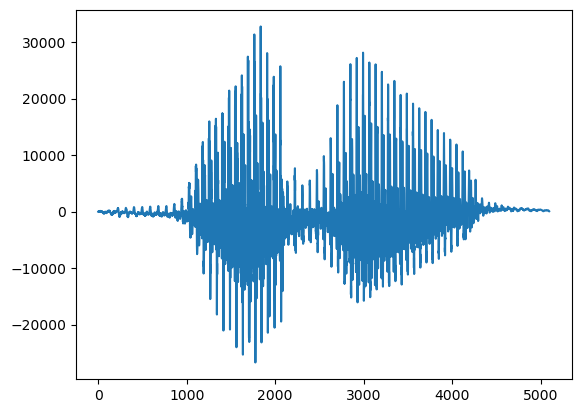

In [2]:
from scipy.io import wavfile

file_path = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [3]:
print(np.fft.ifft(np.log(np.abs(np.fft.fft(wav_data)))).shape)

(5098,)


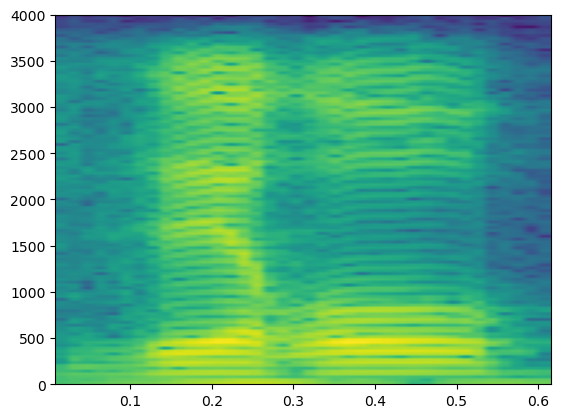

In [4]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

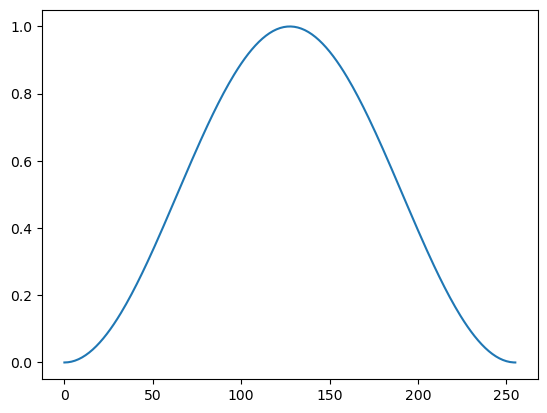

In [5]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [6]:
def feature_extraction(wav_data, window_size = 256, window_shift = 128, cepstral_order = 10):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    
    hann_window = np.hanning(window_size)
    cepstral_vectors = []
    
    for i in range(0, len(wav_data) - window_size, window_shift):
        windowed_data = wav_data[i:i+window_size] * hann_window
        variable = np.log(np.abs(np.fft.fft(windowed_data)))
        variable = (np.fft.ifft(variable)).real
        cepstral_vectors.append(variable[:cepstral_order])
    
    cepstral_vectors = np.array(cepstral_vectors)
    return cepstral_vectors

In [7]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [8]:
5098 // 128 - 1

38

In [9]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $C (l_X \times l_Y)$ such that $C(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $D (l_X \times l_Y)$ such that $D(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $D(i,i)$ then $D(i+1,i), \dots D(l_X,i)$ and $D(i,i+1), D(i,i+2), \dots D(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```D```).

In [10]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    #
    # 
    #
    
    # Calculate the similarity matrix
    C = cdist(x, y) # check if it okay the orientation of x and y
    
    # Initialization of the cumulative distance matrix
    D = np.zeros((len(x), len(y)))
    D[0, 0] = C[0, 0]
    for i in range(1, len(x)):
        D[i, 0] = D[i-1, 0] + C[i, 0]
    for j in range(1, len(y)):
        D[0, j] = D[0, j-1] + C[0, j]
        
    # Calculation of the matrix cumulative distances
    for i in range(1, len(x)):
        for j in range(1,len(y)):
            D[i,j] = min(D[i-1, j-1] + gamma*C[i, j], D[i-1, j] + C[i, j], D[i, j-1] + C[i, j])
    
    
    
    # Backtracking
    
    # Initialization
    M = np.zeros((len(x) + len(y), 2))
    i = len(x) - 1
    j = len(y) - 1
    k = 0
    norm = 0
    M[k, 0] = i
    M[k, 1] = j
    k += 1
    
    # Loop until we reach the first row or column
    while i > 0 and j > 0:
        num_min = min(D[i-1, j-1], D[i-1, j], D[i, j-1] + C[i, j])
        if num_min == D[i-1, j-1]:
            i -= 1
            j -= 1
            norm += gamma
        elif num_min == D[i-1, j]:
            i -= 1
            norm += 1
        else: # num_min == D[i, j-1]
            j -= 1
            norm += 1
        M[k, 0] = i
        M[k, 1] = j
        k += 1
    
    # We reach the first row or column
    if i == 0:
        while j > 0:
            j -= 1
            M[k, 0] = i
            M[k, 1] = j
            norm += 1
            k += 1
    else: # j == 0
        while i > 0:
            i -= 1
            M[k, 0] = i
            M[k, 1] = j
            norm += 1
            k += 1
    
    
    # We remove the unused rows
    M = M[:k, :]
    M = np.flip(M, axis=0)
    
    # Calculating the cumulative distance along the path of least cost
    distance = D[-1, -1] / norm
    
    return D, M, distance

In [11]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

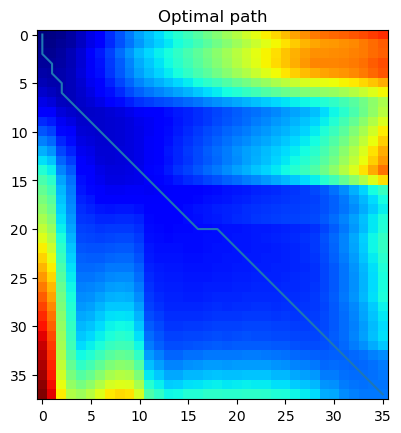

Cost of the optimal path: 0.334072239163323


In [12]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

### Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the $\gamma$ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [13]:
# Function to align a reference sequence with all the others
def align_reference_with_all(gamma):
    dist = []
    min_dist = []
    results = []

    # Reference sequence
    for num in range(0,10):
        file_path = "./SIG/SIG_Rep_1_Number_" + str(num) + ".wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors_ref = feature_extraction(
        wav_data, window_size, window_shift, cepstral_order)
        
        # Calculate the distance for all numbers and repetitions
        for nums in range(0,10):
            for rep in range(1, 13):
                if nums == num and rep == 1:
                    continue
                file_path = "./SIG/SIG_Rep_" + str(rep) + "_Number_" + str(nums) + ".wav"
                sample_rate, wav_data = wavfile.read(file_path)
                cepstral_vectors = feature_extraction(
                wav_data, window_size, window_shift, cepstral_order)
                D, M, distance = time_alignment(cepstral_vectors_ref, cepstral_vectors, gamma=gamma)
                dist.append(distance)
            
            distance = min(dist)
            min_dist.append(distance)
            dist.clear()
        results.append(np.argmin(min_dist))
        min_dist.clear()
    
    results = np.array(results)
    return results

In [14]:
# Select gamma = 2
results = align_reference_with_all(2)
for i in range(0,10):
    print("Number", i, "is the same as number", results[i])

Number 0 is the same as number 0
Number 1 is the same as number 1
Number 2 is the same as number 2
Number 3 is the same as number 3
Number 4 is the same as number 4
Number 5 is the same as number 5
Number 6 is the same as number 6
Number 7 is the same as number 7
Number 8 is the same as number 8
Number 9 is the same as number 9


Taking as a reference a repetition for each number, we compered it in term of distance with every other possible number and repetion. The results are very satisfactory as the minimal distance for each number corresponds to a repetition of that same number.

For answering the question of the influence of gamma, we will calculate the distances as before but chosing an arrange of values of gamma, we will print a message when the minimal distance is given between two diferents numbers.

In [15]:
gammas = np.arange(0.1, 7, 0.5)
for gamma in gammas:
    print("Gamma =", gamma)
    results = align_reference_with_all(gamma)
    for i in range(0,10):
        if i != results[i]:
            print("Number", i, "is not the same as number", results[i])
    

Gamma = 0.1
Number 7 is not the same as number 6
Number 8 is not the same as number 6
Gamma = 0.6
Number 8 is not the same as number 6
Gamma = 1.1
Gamma = 1.6
Gamma = 2.1
Gamma = 2.6
Gamma = 3.1
Gamma = 3.6
Gamma = 4.1
Number 8 is not the same as number 6
Gamma = 4.6
Number 8 is not the same as number 6
Gamma = 5.1
Number 8 is not the same as number 6
Gamma = 5.6
Number 8 is not the same as number 6
Gamma = 6.1
Number 8 is not the same as number 6
Gamma = 6.6
Number 8 is not the same as number 6


As we can see above the chose of gamma has an impact on the distances, it is not a big impact but is noticeable and in certain cases if causes mispredicting a number. A priori, there is an interval of where the values of gamma should be chosen, in this case, between 1 and 4.

For having a better understanding of what is happening we are going to plot the optimal path for two values of gamma, gamma = {0.1, 2}, for the number 8.

Cost of the optimal path with gamma = 0.1 : 1.0299013192635444


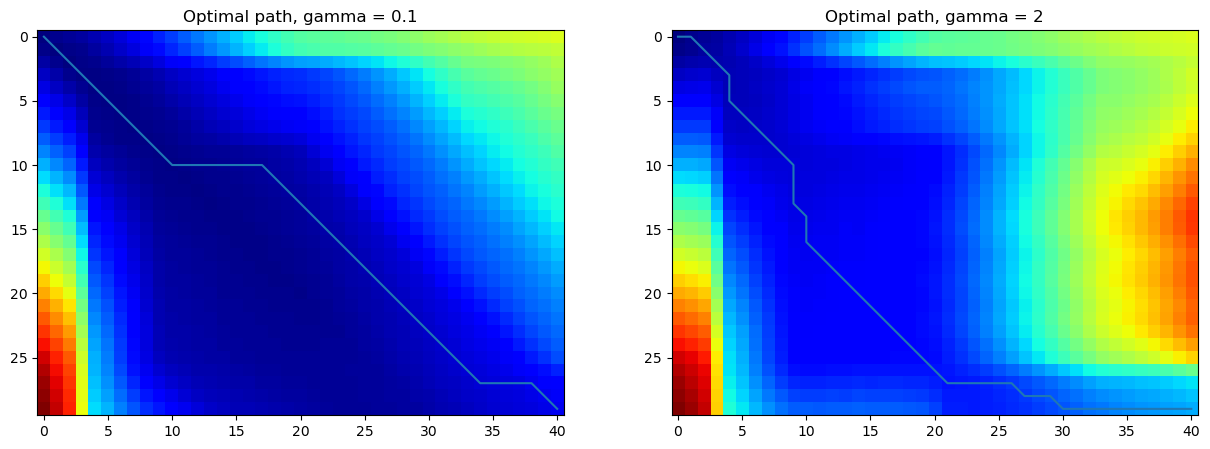

Cost of the optimal path with gamma = 2 : 0.573580142896632


In [16]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_8.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_5_Number_8.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=0.1)


# Example of visualization of the optimal path

plt.figure(figsize=(15, 5))

M = np.array(M)
plt.subplot(1, 2, 1)
plt.imshow(D, cmap='jet')
plt.title("Optimal path, gamma = 0.1")
plt.plot(M[:,1], M[:,0])

print("Cost of the optimal path with gamma = 0.1 :", distance)

D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

M = np.array(M)
plt.subplot(1, 2, 2)
plt.imshow(D, cmap='jet')
plt.title("Optimal path, gamma = 2")
plt.plot(M[:,1], M[:,0])


plt.show()
print("Cost of the optimal path with gamma = 2 :", distance)

What we can see here is that the optimal path is more "straight" when gamma is 0.1, this is because the diagonal path is less weighted. In the other hand, when gamma is 2, the diagonal path is more weighted and the optimal path start to take deviations outside the diagonal. Also we can see that the cost of the optimal path is lower when gamma is 2.

This shows that the selection of gamma is important and it should be done carefully.

For answering the last question, we can explain the following:

Starting with, the linear frequency spectrum coefficients consider all speech frequency ranges of equal importance. And considering that the Euclidean distance assumes that each component of the cepstral vectors contributes equally to the overall distance calculation, each feature of the vectors is equally weighted and independent. This assumption implies that all dimensions of the cepstral vectors are equally relevant for measuring proximity, regardless of their individual meaning or significance in the context of the data. It assumes that the distance between two cepstral vectors is solely determined by the absolute differences between their corresponding feature values.

However this hypothesis may not hold true when comparing aligned sequences of the same number. The temporal variations in the speech signal, such as variations in pronunciation, speaking rate, can introduce differences in the cepstral vectors that are not adequately captured by Euclidean distance alone.

For example, the cepstral vectors of two repetitions of the same number may have similar values for most of the cepstral coefficients, but differ in a few coefficients due to temporal variations. In this case, the Euclidean distance between the two cepstral vectors will be large, even though the two repetitions are similar.

To address this issue, we can propose a method that incorporates the DTW alignment and estimates appropriate weights based on the normalised distances. This method consists of the following steps:

    Perform DTW alignment: Apply the DTW algorithm to align the sequences of cepstral vectors corresponding to different repetitions of the same word. This alignment will find the optimal mapping between the frames of the sequences, accounting for temporal variations and differences in timing (matrix M).

    Calculate frame-wise distances: For each pair of aligned frames obtained from the DTW alignment, calculate the distance between their cepstral vectors. This distance can be computed using Euclidean distance.

    Normalize frame-wise distances: Normalise the frame-wise distances obtained in the previous step to make them comparable across different repetitions. A possible approach is to divide each distance value by the maximum distance value in the alignment. This normalisation ensures that the distances are relative and not affected by the length or magnitude of the aligned sequences.

    Weight calculation: Calculate the weights for each frame or cepstral vector. One possible approach is to assign higher weights to frames with smaller normalised distances, indicating higher similarity. This can be done by taking the inverse of the normalized distances.

    Weighted comparison: Finally, when comparing cepstral vectors from different repetitions of the same number, multiply each cepstral vector by its corresponding weight calculated in the previous step. This weighting scheme emphasizes the frames that have higher similarity across repetitions and de-emphasizes frames with larger dissimilarity.

By incorporating the DTW alignment and estimating appropriate weights based on the normalised distances, this method allows for a more refined comparison of cepstral vectors from different repetitions of the same number. It assigns weights to highlight the more similar frames, providing a more accurate representation of the true similarity between the repetitions.

## Evaluation of Speech Recognition

The goal of this part is to implement an evaluation strategy in order to check how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. Ideally, we would need to rotate the reference/unknown sets to perform cross-validation - but we can work with a random choice of only one reference for each number to simplify the setup. 
To do so, write a function ```classification```. For example, you can use the following formalism : 

```[confusion, accuracy] = classification(vectors, gamma)```

- ```vectors``` contains all the cepstral vectors for the signals in the chosen dataset. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate (averaged over cross-validation experiments if used).

In [17]:
# Calculate the vectors for all the signals in the dataset
def vector_extractor(dataset, window_size=256 , window_shift=128, cepstral_order=10):
    
    if dataset == "SIG":
        MAX_REP = 12
    elif dataset == "SIG2":
        MAX_REP = 6
    elif dataset == "SIGMIX":
        MAX_REP = 12
    else:
        print("Dataset not found")
        return
    
    # List of matrices containing the cepstral vectors for all signals
    vectors = []

    for nums in range(0,10):
        for reps in range(1,MAX_REP+1):
            file_path = "./" + dataset + "/" + dataset + "_Rep_" + str(reps) + "_Number_" + str(nums) + ".wav"
            sample_rate, wav_data = wavfile.read(file_path)
            cepstral_vectors = feature_extraction(
            wav_data, window_size, window_shift, cepstral_order)
            vectors.append(cepstral_vectors)
    return vectors


In [18]:
vectors = vector_extractor("SIG2")

print("Vector contains all repetitions of the numbers 0 and then all repetitions of the number 1, and so on.")
print("Shape of one element of the vector list: ", vectors[1].shape)
print("Number of repetitions: ", int(len(vectors)/10), ". Length of the vector: ",  len(vectors))


Vector contains all repetitions of the numbers 0 and then all repetitions of the number 1, and so on.
Shape of one element of the vector list:  (36, 10)
Number of repetitions:  6 . Length of the vector:  60


In [19]:
# Define function to calculate the confusion matrix and the accuracy
def classification(vectors, gamma):
    # Initialize confusion matrix
    confusion = np.zeros((10,10))
    # Initialize accuracy
    accuracy = 0
    # Initialize counter for the number of correct classifications
    correct = 0
    # Get the reference vectors
    nbr_reps = len(vectors)/10
    random_reference = np.random.randint(0, nbr_reps)
    reference_vectors = vectors[random_reference::int(nbr_reps)]
    
    # Loop over the unknown vectors
    for i in range(len(vectors)):
        # Initialize the minimum distance
        min_dist = np.inf
        # Initialize the index of the reference vector
        index = 0
        # Skip evaluation two same vectors
        if i%int(nbr_reps) == random_reference:
            continue
        # Loop over the reference vectors
        for j in range(len(reference_vectors)):
            # Calculate the distance between the unknown vector and the reference vector
            _, _, dist = time_alignment(vectors[i], reference_vectors[j], gamma)
            # Update the minimum distance and the index of the reference vector
            if dist < min_dist:
                min_dist = dist
                index = j
        # Update the confusion matrix
        confusion[int(i/(nbr_reps))][index] += 1
        # Update the counter for the number of correct classifications
        if int(i/nbr_reps) == index:
            correct += 1
    
    # Calculate the accuracy
    accuracy = correct/(len(vectors)-len(reference_vectors))
    
    return confusion, accuracy


Questions: 
- Evaluate the speech recognition performance on the data ```SIG```, and then on the data ```SIG2```. Visualize the confusion matrices ? 
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Try to interpret the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose (shortly) possible solutions to these problems.

### Answers

Imports

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

Performance for dataset ```SIG```:

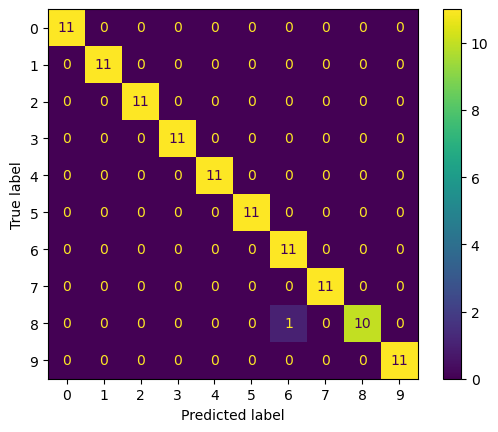

Accuracy:  0.990909090909091


In [28]:
vectors = vector_extractor("SIG")

[confusion, accuracy] = classification(vectors, 2)

# Print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=np.arange(10))
disp.plot()
plt.show()

# Print the accuracy
print("Accuracy: ", accuracy)

The performance of the speech recognition on the dataset ```SIG``` is very good. The accuracy is very good and may vary depending on the aleatory reference taken, the confusion matrix is almost diagonal, which means that most of the numbers are classified correctly.

Performance for dataset ```SIG2```:

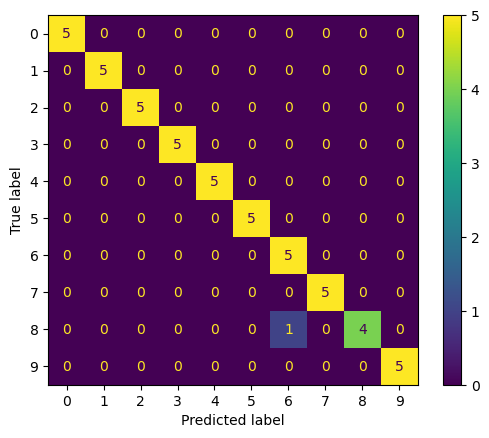

Accuracy:  0.98


In [25]:
vectors = vector_extractor("SIG2")

[confusion, accuracy] = classification(vectors, 2)

# Print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=np.arange(10))
disp.plot()
plt.show()

# Print the accuracy
print("Accuracy: ", accuracy)

The performance of the speech recognition on the dataset ```SIG2``` is very good as well. The accuracy is very good and may vary depending on the aleatory reference taken, the confusion matrix is almost diagonal, which means that most of the numbers are classified correctly.

Generalisation capacity for dataset ```SIGMIX```:

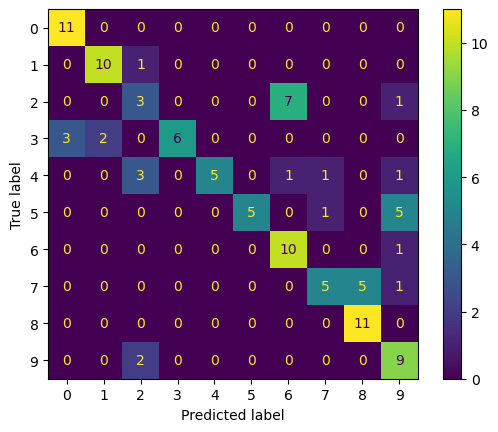

Accuracy:  0.6818181818181818


In [26]:
vectors = vector_extractor("SIGMIX")

[confusion, accuracy] = classification(vectors, 2)

# Print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=np.arange(10))
disp.plot()
plt.show()

# Print the accuracy
print("Accuracy: ", accuracy)

The performance of the speech recognition on the dataset ```SIGMIX``` is very bad. The accuracy is very bad and may vary depending on the aleatory reference taken, the confusion matrix is not diagonal at all, which means that most of the numbers are classified incorrectly. This is due to the fact that the dataset ```SIGMIX``` contains the numbers pronounced by different speakers, which means that the cepstral vectors are different for the same number. The dynamic time warping algorithm is not able to recognize the numbers because the cepstral vectors are different for the same number.

The answer above opens the dicussion of the limitations of dynamic time warping approaches for speech recognition:

    Lack of global information: The different pronunciations of the same number by different speakers can lead to incorrect alignments and recognition errors.

    A possible solution: Integrating global information can enhance the alignment and recognition accuracy. One approach is to incorporate language models or phonetic knowledge to guide the alignment process and bias it towards linguistically plausible alignments.